In [32]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os
import glob as glob
from pathlib import Path
from datetime import datetime
import json

from pyannote.audio import Pipeline
from pyannote.core import json
from pyannote.core.timeline import Timeline

import moviepy.editor as mp

from matplotlib import pyplot as plt, lines
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src import (
    downsample as downsamp_audio, 
    embedding_extractor as ee, 
    dimension_reducer as dr, 
    distance_metrics as dm, 
    downsample as ds,
    emb_manipulator as em
)

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def extract_audio_from_video_and_return_path(root_dir):
    #takes in root directory
    #extracts audio from video and puts it in /audio
    #also returns the location of the audio (bad practice but works!)
    
    vid_files = glob.glob(root_dir + '/*', recursive=True)
    {Path(vid).stem:
               vid for vid in vid_files}

    my_clip = {Path(vid).stem:
               mp.VideoFileClip(vid) for vid in vid_files}

    aud_files = os.path.join(root_dir,'audio')

    if not os.path.exists(aud_files):
        os.mkdir(aud_files)

    [mov.audio.write_audiofile(os.path.join(aud_files,part + '.wav')) for part,mov in my_clip.items()]
    
    return aud_files

def extract_16khz_audio(root_dir, video=False):
    
    #outputs audio downsampled to 16khz, returns the path of the audio
    #if the input is video, will extract audio at 44khz first then downsample
    #otherwise will just downsample
    
    #if data is in video format, extract audio
    
    if video:
        aud_files = extract_audio_from_video_and_return_path(root_dir)
    else:
        aud_files = root_dir

    
    #downsample audio (either extracted from folder or given to me)
    
    #make a folder with today's date for the downsampled audio if it doesn't exist
    down_sample_dir = os.path.join(root_dir,"audio_16kz")
    if not os.path.exists(down_sample_dir):
        os.mkdir(down_sample_dir)
    
    ds.downsamp_audio(aud_files, down_sample_dir)
    
    return down_sample_dir   

In [25]:
##Downsample audio to 16kHz
root_dir= "/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced"
!ls $root_dir

011_Reduced.wav               BB006_BookReading_Reduced.wav
012_Reduced.wav               BB007_BookReading_Reduced.wav
013_Reduced.wav               BB008_BookReading_Reduced.wav
014_Reduced.wav               BB012_BookReading_Reduced.wav
015_Reduced.wav               BB013_BookReading_Reduced.wav
016_Reduced.wav               BB014_BookReading_Reduced.wav
017_Reduced.wav               BB016_BookReading_Reduced.wav
018_Reduced.wav               BB019_BookReading_Reduced.wav
019_Reduced.wav               BB020_BookReading_Reduced.wav
020_Reduced.wav               BB021_BookReading_Reduced.wav
021_Reduced.wav               BB022_BookReading_Reduced.wav
022_Reduced.wav               BB038_BookReading_Reduced.wav
BB002_BookReading_Reduced.wav BB042_BookReading_Reduced.wav
BB003_BookReading_Reduced.wav audio_16kz
BB005_BookReading_Reduced.wav


In [98]:
down_sample_dir = extract_16khz_audio(root_dir, video=False)

processing022_Reduced.wav


In [29]:
##Diarize audio to find when mother is speaking and visualize it to choose label

diar_dir = os.path.join(root_dir,'diarized')
  
if not os.path.exists(diar_dir):
    os.mkdir(diar_dir)

diar_dir

'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/diarized'

In [19]:
## Runs speaker diariztion, but should run on openmind

#pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization@2022.07")

#for file in os.listdir(down_sample_dir):
#    if file.endswith('wav'):
#        diar = pipeline(os.path.join(down_sample_dir,file))
#        json.dump_to(diar, os.path.join(diar_dir, os.path.splitext(file)[0]+'.json'))

In [53]:
diarized_raw = {os.path.splitext(file)[0]:
            json.load_from(os.path.join(diar_dir,file)) for file in os.listdir(diar_dir)}
diarized_raw.keys()

dict_keys(['BB019', '011', 'BB042', 'BB003', 'BB038', 'BB002', 'BB014', 'BB022', 'BB013', 'BB005', '021', '017', 'BB008', '016', '020', 'BB012', 'BB007', '019', '015', '014', 'speaker_map', 'BB006', '018', '022', 'BB021', '013', 'BB016', '012', 'BB020'])

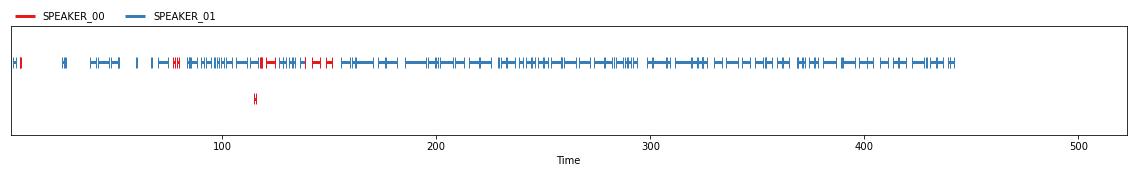

In [48]:
diarized_raw['021']

In [91]:
speaker_map_json = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/diarized/speaker_map.json'
with open(speaker_map_json) as json_file:
    speaker_map = json.load(json_file)

len(speaker_map.keys())

28

In [112]:
# Based on output of diarization, manually make speaker map to set which speaker we want
temp = {label:[diarized_raw[label].label_timeline(s) for s in s_list]
        for label,s_list in speaker_map.items() 
       }

diarized = {}

for label, all_timelines in temp.items():
    all_seg = Timeline()
    for timeline in all_timelines:
        all_seg = all_seg.union(timeline)
    
    if 'BB' in label:
        diarized[label + '_BookReading_Reduced'] = all_seg
    else:
        diarized[label + '_Reduced'] = all_seg

In [113]:
diarized.keys()

dict_keys(['011_Reduced', '012_Reduced', '013_Reduced', '014_Reduced', '015_Reduced', '016_Reduced', '017_Reduced', '018_Reduced', '019_Reduced', '020_Reduced', '021_Reduced', '022_Reduced', 'BB003_BookReading_Reduced', 'BB042_BookReading_Reduced', 'BB002_BookReading_Reduced', 'BB007_BookReading_Reduced', 'BB019_BookReading_Reduced', 'BB038_BookReading_Reduced', 'BB014_BookReading_Reduced', 'BB022_BookReading_Reduced', 'BB013_BookReading_Reduced', 'BB005_BookReading_Reduced', 'BB008_BookReading_Reduced', 'BB012_BookReading_Reduced', 'BB006_BookReading_Reduced', 'BB021_BookReading_Reduced', 'BB016_BookReading_Reduced', 'BB020_BookReading_Reduced'])

In [114]:
emb_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
save_name = datetime.now().strftime('%Y_%m_%d') + '_noise_reduced.csv'
diarized = diarized

import glob
#all_files = glob.glob(down_sample_dir+'/*/*', recursive=True)
#all_files = [file for file in all_files if 'script' in file]

all_files = glob.glob(down_sample_dir+'/*', recursive=True)

save_name, all_files

('2022_08_09_noise_reduced.csv',
 ['/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/audio_16kz/017_Reduced.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/audio_16kz/012_Reduced.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/audio_16kz/BB013_BookReading_Reduced.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/audio_16kz/020_Reduced.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/audio_16kz/BB022_BookReading_Reduced.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/audio_16kz/BB021_BookReading_Reduced.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/audio_16kz/011_Reduced.wav',
  '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/audio_16kz/018_Reduced.wav',
  '/Users/rah

In [115]:
pyannote_emb = ee.pyannote_extract_directory(all_files, diarized,emb_dir,save_name,window_type="sliding",save=True)
pyannote_emb

Processing/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/Noise_Reduced/audio_16kz/022_Reduced.wav
Done


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,part_id
0,-4.608624,-7.828435,-44.208649,-57.331032,42.250492,38.816906,-13.384706,41.988503,7.159103,-15.172543,...,-11.767054,-56.246159,-39.610229,-11.847515,-31.559448,-29.001574,38.027382,87.941284,-1.699499,017_Reduced
1,19.973576,-42.004807,7.759827,-34.831352,53.216415,-1.521076,-25.972950,51.142056,4.375884,29.312283,...,-45.585396,-21.619654,-23.786283,15.219593,-25.992374,-80.289009,29.723768,62.479145,-7.770151,017_Reduced
2,28.958241,-15.645761,23.976742,-44.265453,40.815453,59.720100,-30.813951,39.506687,6.214677,8.970301,...,-31.355505,-50.927158,-34.119209,34.955090,-41.167721,-97.135277,13.132444,31.589581,-1.477311,017_Reduced
3,5.500264,-40.238834,20.488455,-37.724236,-28.112629,45.064617,-10.780781,60.481628,26.928501,-10.609280,...,-60.040413,-27.773731,-57.355934,-72.617004,-66.289322,7.680530,32.288330,56.846294,42.754475,017_Reduced
4,57.556034,-38.128757,21.354469,-28.984150,-10.594023,-15.588057,46.224197,20.586002,-9.697031,-54.265461,...,-64.968956,14.179516,-16.496441,2.263725,17.743719,-47.888962,-30.059258,106.521500,35.731701,017_Reduced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,12.584605,13.073392,-18.299404,-44.564507,4.448109,19.233971,5.654045,5.764571,-27.594563,11.799312,...,-22.956589,-79.967255,-13.516647,2.634180,-9.125813,-29.266176,-73.055161,24.369095,-8.847913,022_Reduced
877,45.669933,28.416275,-3.039303,-52.150551,-10.036665,42.034431,12.689316,14.840410,0.417658,6.292319,...,-5.744398,-47.534462,-21.802401,18.660301,-24.470856,-18.696110,-105.273254,-37.120209,-26.040165,022_Reduced
878,26.039722,6.150116,-0.265453,-47.014446,-25.350151,-13.722067,21.002012,-2.146047,17.398207,-5.247840,...,36.820152,-69.746887,-44.616604,-15.017632,-20.619164,5.227482,-76.509773,-19.495834,-20.890717,022_Reduced
879,52.091331,-54.071404,54.686806,1.552494,37.613659,24.153622,-17.730608,-12.850696,-20.631405,58.553497,...,-14.121399,-11.153786,0.719539,18.095558,-51.323593,-26.290112,-0.922419,1.091248,6.440983,022_Reduced


In [116]:
len(all_files)

28

In [117]:
emb = pd.read_csv(os.path.join(emb_dir,save_name), index_col=0)
emb.shape

(881, 513)

In [121]:
emb.part_id.unique(), emb.part_id.unique().shape

(array(['017_Reduced', '012_Reduced', 'BB013_BookReading_Reduced',
        '020_Reduced', 'BB022_BookReading_Reduced',
        'BB021_BookReading_Reduced', '011_Reduced', '018_Reduced',
        'BB003_BookReading_Reduced', 'BB014_BookReading_Reduced',
        'BB007_BookReading_Reduced', '014_Reduced',
        'BB008_BookReading_Reduced', '021_Reduced', '013_Reduced',
        'BB012_BookReading_Reduced', 'BB016_BookReading_Reduced',
        'BB019_BookReading_Reduced', 'BB005_BookReading_Reduced',
        '016_Reduced', '015_Reduced', 'BB006_BookReading_Reduced',
        'BB038_BookReading_Reduced', 'BB002_BookReading_Reduced',
        '019_Reduced', 'BB042_BookReading_Reduced',
        'BB020_BookReading_Reduced', '022_Reduced'], dtype=object),
 (28,))

In [122]:
emb

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,part_id
0,-4.608624,-7.828435,-44.208649,-57.331032,42.250492,38.816906,-13.384706,41.988503,7.159103,-15.172543,...,-11.767054,-56.246159,-39.610229,-11.847515,-31.559448,-29.001574,38.027382,87.941284,-1.699499,017_Reduced
1,19.973576,-42.004807,7.759827,-34.831352,53.216415,-1.521076,-25.972950,51.142056,4.375884,29.312283,...,-45.585396,-21.619654,-23.786283,15.219593,-25.992374,-80.289009,29.723768,62.479145,-7.770151,017_Reduced
2,28.958241,-15.645761,23.976742,-44.265453,40.815453,59.720100,-30.813951,39.506687,6.214677,8.970301,...,-31.355505,-50.927158,-34.119209,34.955090,-41.167721,-97.135277,13.132444,31.589581,-1.477311,017_Reduced
3,5.500264,-40.238834,20.488455,-37.724236,-28.112629,45.064617,-10.780781,60.481628,26.928501,-10.609280,...,-60.040413,-27.773731,-57.355934,-72.617004,-66.289322,7.680530,32.288330,56.846294,42.754475,017_Reduced
4,57.556034,-38.128757,21.354469,-28.984150,-10.594023,-15.588057,46.224197,20.586002,-9.697031,-54.265461,...,-64.968956,14.179516,-16.496441,2.263725,17.743719,-47.888962,-30.059258,106.521500,35.731701,017_Reduced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,12.584605,13.073392,-18.299404,-44.564507,4.448109,19.233971,5.654045,5.764571,-27.594563,11.799312,...,-22.956589,-79.967255,-13.516647,2.634180,-9.125813,-29.266176,-73.055161,24.369095,-8.847913,022_Reduced
877,45.669933,28.416275,-3.039303,-52.150551,-10.036665,42.034431,12.689316,14.840410,0.417658,6.292319,...,-5.744398,-47.534462,-21.802401,18.660301,-24.470856,-18.696110,-105.273254,-37.120209,-26.040165,022_Reduced
878,26.039722,6.150116,-0.265453,-47.014446,-25.350151,-13.722067,21.002012,-2.146047,17.398207,-5.247840,...,36.820152,-69.746887,-44.616604,-15.017632,-20.619164,5.227482,-76.509773,-19.495834,-20.890717,022_Reduced
879,52.091331,-54.071404,54.686806,1.552494,37.613659,24.153622,-17.730608,-12.850696,-20.631405,58.553497,...,-14.121399,-11.153786,0.719539,18.095558,-51.323593,-26.290112,-0.922419,1.091248,6.440983,022_Reduced
